In [1]:
import sys
sys.path.append('../src/')
import math

import numpy as np
import scipy
from scipy.stats import norm, lognorm

import matplotlib.pyplot as plt

A review of [Jain et al.'s (2023)](https://arxiv.org/abs/2303.01598) prediction model for our setting (not few-shot setting).

They define

\begin{align}
1-\hat{v}(n_i) &= \theta_1 n^{\theta_2}
\end{align}

and

\begin{align}
\hat{y}_i &= \log(1-\hat{v}(n_i)) \\
&= \log(1 - (1 - \theta_1 n^{\theta_2})) \\
&= \log(1 - 1 + \theta_1 n^{\theta_2}) \\
&= \log(\theta_1) + \log(n^{\theta_2}) \\
&= \log(\theta_1) + \theta_2\log(n).
\end{align}

Then they represent their model in the form

\begin{align}
\alpha(x) &= [1, \log(n)] \\
\theta &= [\log(\theta_1), \theta_2]^T.
\end{align}

Note: both $\alpha$ and $\theta$ should be bold.

They define

\begin{align}
\Sigma_\theta = (J^TJ)^{-1}, J = \left[ \frac{\partial \mathbf{\hat{y}}}{\partial \theta} \right]
\end{align}


where $J \in \mathcal{R}^{m\times2}$, $m$ is the number of training samples, and

\begin{align}
\frac{\partial \mathbf{\hat{y}}}{\partial \theta_1} &= 1 \\
\frac{\partial \mathbf{\hat{y}}}{\partial \theta_2} &= \log(n).
\end{align}

They define the mean and variance for the log domain as

\begin{align}
\mu_{\hat{y}}(n) &= \hat{y} \\
\sigma^2_{\hat{y}}(n) &= \alpha^T(n)\Sigma_\theta\alpha(n).
\end{align}

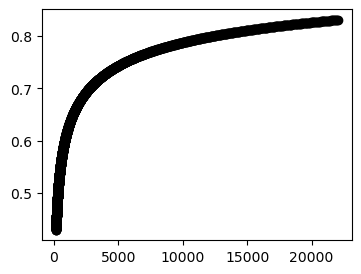

In [110]:
X = [200, 240, 280, 320, 360, 800, 1600, 3200, 6400, 12800, 25600]
y = [0.7394, 0.7379, 0.7443, 0.7464, 0.7449, 0.7660, 0.7845, 0.8041, 0.8148, 0.8245, 0.8291]
# For an example where both Xs and ys fall on a log scale use uncomment X and y below
X = np.exp(np.logspace(0.7, 1, 2000))
y = 1-np.exp(-np.logspace(-0.25, 0.25, 2000))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(X, y, color='black')
fig.show()

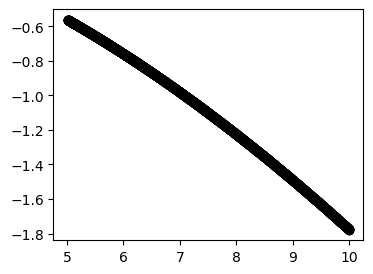

In [111]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(np.log(X), np.log(1-np.array(y)), color='black')
fig.show()

In [112]:
# Train and test split
X_with_bias = np.insert(np.log(X)[:,np.newaxis], 0, 1, axis=1)
n_training_samples = 1000
X_train, y_train = X_with_bias[:n_training_samples], np.log(1-np.array(y))[:n_training_samples]
X_test, y_test = X_with_bias[n_training_samples:], np.log(1-np.array(y))[n_training_samples:]

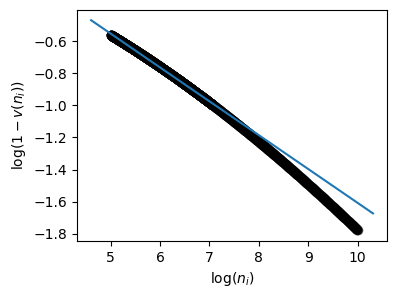

In [113]:
# Define linspace to predict
samples = np.linspace(100, 30000, 1000)
log_samples = np.log(samples)
# Fit least squares in log space
thetas, residuals, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
alphas = np.array([[[1], [x]] for x in log_samples])
y_means = np.array([float(alpha.T@thetas) for alpha in alphas])
# Plot mean prediction
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(X_train[:,1], y_train, color='black', alpha=1.0)
ax.scatter(X_test[:,1], y_test, color='black', alpha=0.3)
ax.plot(log_samples, y_means)
ax.set_xlabel(r'$\log(n_i)$')
ax.set_ylabel(r'$\log(1-v(n_i))$')
fig.show()

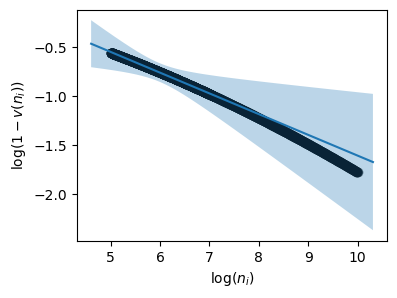

In [114]:
# Calculate Jacobian and Sigma
J = np.array([[1, x] for x in X_train[:,1]])
Sigma = np.linalg.inv(J.T@J)
y_sigmas = np.array([float(alpha.T@Sigma@alpha) for alpha in alphas])
y_lowers = y_means-(3*np.sqrt(y_sigmas))
y_uppers = y_means+(3*np.sqrt(y_sigmas))
# Plot uncertainty
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(X_train[:,1], y_train, color='black', alpha=1.0)
ax.scatter(X_test[:,1], y_test, color='black', alpha=0.3)
ax.plot(log_samples, y_means)
ax.fill_between(log_samples, y_lowers, y_uppers, alpha=0.3)
ax.set_xlabel(r'$\log(n_i)$')
ax.set_ylabel(r'$\log(1-v(n_i))$')
fig.show()

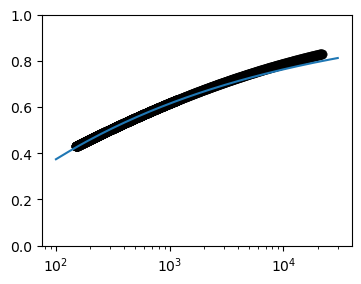

In [115]:
means = [norm(loc=y_mean, scale=np.sqrt(y_sigma)).mean() for y_mean, y_sigma in zip(y_means, y_sigmas)]
# Plot uncertainty
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(np.exp(X_train[:,1]), 1-np.exp(y_train), color='black', alpha=1.0)
ax.scatter(np.exp(X_test[:,1]), 1-np.exp(y_test), color='black', alpha=0.3)
ax.plot(samples, 1-np.exp(means))
ax.set_ylim([0.0, 1.0])
ax.set_xscale('log')
fig.show()

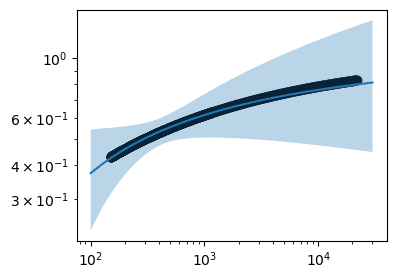

In [116]:
means = [lognorm(s=np.sqrt(y_sigma), loc=-np.exp(y_mean)).ppf(0.5) for y_mean, y_sigma in zip(y_means, y_sigmas)]
lowers = [lognorm(s=np.sqrt(y_sigma), loc=-np.exp(y_mean)).ppf(0.025) for y_mean, y_sigma in zip(y_means, y_sigmas)]
uppers = [lognorm(s=np.sqrt(y_sigma), loc=-np.exp(y_mean)).ppf(0.975) for y_mean, y_sigma in zip(y_means, y_sigmas)]
# Plot uncertainty
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(np.exp(X_train[:,1]), 1-np.exp(y_train), color='black', alpha=1.0)
ax.scatter(np.exp(X_test[:,1]), 1-np.exp(y_test), color='black', alpha=0.3)
ax.plot(samples, means)
ax.fill_between(samples, lowers, uppers, alpha=0.3)
#ax.set_ylim([0.0, 1])
ax.set_xscale('log')
ax.set_yscale('log')
fig.show()